## This notebook contains a basic CNN trained on the MFCC coefficients


In [1]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from keras.utils import to_categorical

from keras import layers
from keras.models import Model, Sequential

from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential

from sklearn.utils import compute_class_weight

from keras.models import model_from_json

Matplotlib is building the font cache using fc-list. This may take a moment.
Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [59]:
train_audio_path = 'meld/train/'
val_audio_path='meld/val/'
categ=os.listdir(train_audio_path)

In [4]:
print(categ)

['disgust', 'fear', 'happy', 'neutral', 'sad']


In [5]:
emotion2int = {
    "disgust": "0",
    "fear": "1",
    "happy": "2",
    "neutral": "3",
    "sad": "4",
}

#### Preparing the training data by considering only one second of the audio file and ignoring the audiofiles that are less than a second this is not the best method to do but for time being I am doing like this

In [27]:
X_train,Y_train=[],[]
for c in categ:
    files=os.listdir(train_audio_path+c)
    for f in files:
        rate,signal=wavfile.read(train_audio_path+c+'/'+f)
        #taking average of the 2 channel data
        signal=(signal[:,0]+signal[:,1])/2
        if(signal.shape[0]>rate):
            mel=mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=400).T
            #print(mel.shape)
            y=emotion2int[c]
            X_train.append(mel)
            Y_train.append(y)

In [29]:
X_train=np.array(X_train)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
print(X_train.shape)

(6675, 13, 99, 1)


In [35]:
Y_train=np.array(Y_train)
print(Y_train.shape[0])
Y_train=Y_train.reshape(Y_train.shape[0])
y_flat=Y_train
Y_train=to_categorical(Y_train,num_classes=5)
print(Y_train[4])

[1. 0. 0. 0. 0.]


In [60]:
X_val,Y_val=[],[]
for c in categ:
    files=os.listdir(val_audio_path+c)
    for f in files:
        rate,signal=wavfile.read(val_audio_path+c+'/'+f)
        #taking average of the 2 channel data
        signal=(signal[:,0]+signal[:,1])/2
        if(signal.shape[0]>rate):
            mel=mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=400).T
            #print(mel.shape)
            y=emotion2int[c]
            X_val.append(mel)
            Y_val.append(y)

In [61]:
X_val=np.array(X_val)
X_val=X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],1)
print(X_val.shape)

(774, 13, 99, 1)


In [63]:
Y_val=np.array(Y_val)
print(Y_val.shape[0])
Y_val=Y_val.reshape(Y_val.shape[0])
y_val_flat=Y_val
Y_val=to_categorical(Y_val,num_classes=5)
print(Y_val[4])

774
[1. 0. 0. 0. 0.]


### class weights to deal with unbalanced data

In [36]:
class_weight=compute_class_weight('balanced',np.unique(y_flat),y_flat)

In [37]:
print(class_weight)

[5.98654709 6.675      0.92196133 0.32293179 1.99253731]


### as planned this is a basic cnn with all the typical hyperparameters
max pooling and batch normalization is skipped as of now

In [48]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(5,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model


In [49]:
input_shape=(X_train.shape[1],X_train.shape[2],1)
model=get_conv_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 13, 99, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 99, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 99, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 99, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 49, 128)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 49, 128)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 37632)             0         
__________

In [64]:
history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=10,batch_size=32,shuffle=True,class_weight=class_weight)

Train on 6675 samples, validate on 774 samples
Epoch 1/10
6675/6675 [==============================] - 154s 23ms/step - loss: 0.4886 - acc: 0.8100 - val_loss: 1.6797 - val_acc: 0.5853
Epoch 2/10
6675/6675 [==============================] - 154s 23ms/step - loss: 0.3817 - acc: 0.8545 - val_loss: 1.9695 - val_acc: 0.5801
Epoch 3/10
6675/6675 [==============================] - 180s 27ms/step - loss: 0.3303 - acc: 0.8758 - val_loss: 1.9851 - val_acc: 0.5853
Epoch 4/10
6675/6675 [==============================] - 181s 27ms/step - loss: 0.2590 - acc: 0.9043 - val_loss: 2.0875 - val_acc: 0.5310
Epoch 5/10
6675/6675 [==============================] - 184s 28ms/step - loss: 0.2470 - acc: 0.9110 - val_loss: 2.1957 - val_acc: 0.5982
Epoch 6/10
6675/6675 [==============================] - 166s 25ms/step - loss: 0.1945 - acc: 0.9347 - val_loss: 2.3772 - val_acc: 0.5827
Epoch 7/10
6675/6675 [==============================] - 160s 24ms/step - loss: 0.1686 - acc: 0.9467 - val_loss: 2.4490 - val_acc: 0

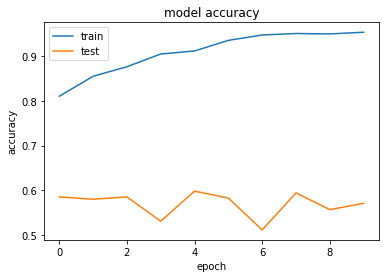

In [65]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

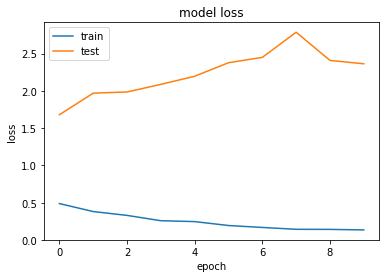

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It can be observed that the model is clearly overfitting ... given that the less number of training examples and low complexity of the model it can be so

### not too good accuracy so i guess more of the preprocessing needs to be done

In [66]:
# serialize model to JSON
model_json = model.to_json()
with open("CNN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_weights.h5")
print("Saved model to disk")

Saved model to disk


In [67]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [68]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
score = loaded_model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 89.65%
